In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')

In [3]:
data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [4]:
stop_words = stopwords.words('english')
def process_text(text):
    text = re.sub(r'\d+',' ',text)
    text = text.split()
    text = " ".join([word for word in text if word.lower().strip() not in stop_words])
    return text
text = data['Review'].apply(process_text)

In [5]:
tokenizer = Tokenizer(num_words=49535)
tokenizer.fit_on_texts(text)
text = tokenizer.texts_to_sequences(text)
max_length = np.max(list(map(lambda x : len(x),text)))

In [6]:
text = pad_sequences(text,maxlen=max_length,padding='post')

In [7]:
y = data['Rating'].apply(lambda x : 1 if x == 5 else 0 )
x = text

In [8]:
x_train , x_test , y_train , y_test = train_test_split(x,y,train_size=0.743,random_state=13)

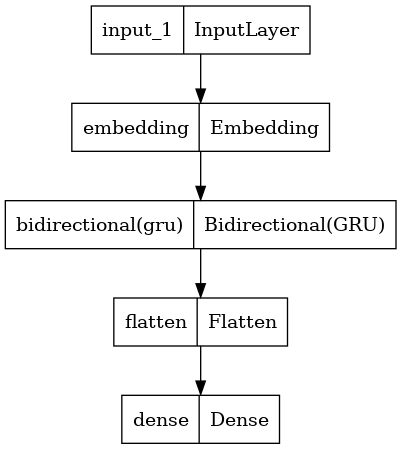

In [9]:
inputs = tf.keras.Input(shape=(max_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=49535
    ,output_dim=64
    ,input_length=max_length
)(inputs)

gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True))(embedding)

x = tf.keras.layers.Flatten()(gru)

output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs,outputs=output)

tf.keras.utils.plot_model(model)

In [10]:
model.compile(
    optimizer='adam'
    ,loss='binary_crossentropy'
    ,metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
)

In [11]:
hist = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy'
        ,patience=3
        ,restore_best_weights=True
    )
)

Epoch 1/100
381/381 [==============================] - 131s 324ms/step - loss: 0.5047 - accuracy: 0.7396 - auc: 0.8265 - val_loss: 0.4333 - val_accuracy: 0.7934 - val_auc: 0.8801
Epoch 2/100
381/381 [==============================] - 98s 258ms/step - loss: 0.2819 - accuracy: 0.8845 - auc: 0.9508 - val_loss: 0.4846 - val_accuracy: 0.7780 - val_auc: 0.8633
Epoch 3/100
381/381 [==============================] - 84s 221ms/step - loss: 0.1083 - accuracy: 0.9612 - auc: 0.9928 - val_loss: 0.6895 - val_accuracy: 0.7655 - val_auc: 0.8444
Epoch 4/100
381/381 [==============================] - 73s 191ms/step - loss: 0.0299 - accuracy: 0.9895 - auc: 0.9994 - val_loss: 0.9767 - val_accuracy: 0.7406 - val_auc: 0.8218


In [12]:
model.evaluate(x_test,y_test)

165/165 [==============================] - 10s 61ms/step - loss: 0.4331 - accuracy: 0.7999 - auc: 0.8805


[0.43312355875968933, 0.7998861074447632, 0.8805129528045654]

# https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

# thank you so much for watching my code